In [1]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

In [2]:
metadata_path = "data/cifar-100-python/meta"  # change this path`\
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b"coarse_label_names"])))

In [5]:
import numpy as np

data_pre_path = "data/cifar-100-python/"  # change this path
# File paths
data_train_path = data_pre_path + "train"
data_test_path = data_pre_path + "test"
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b"data"]
label_train = np.array(data_train_dict[b"coarse_labels"])
data_test = data_test_dict[b"data"]
label_test = np.array(data_test_dict[b"coarse_labels"])

In [10]:
data_train[1].shape

(3072,)

In [19]:
import torch
import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
testset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
index = np.where(np.array(trainset.targets) == 0)[0]

In [51]:
np.take(trainset.data, index, axis=0).shape

(500, 32, 32, 3)

In [26]:
np.take([2, 3, 4], [0, 1])

array([2, 3])

In [7]:
from cbir.datasets.cifar100 import CIFAR100CBIRDaset

dataset = CIFAR100CBIRDaset(h_type="global")

KeyboardInterrupt: 

In [7]:
dataset[1][0].shape

torch.Size([3, 32, 32])

In [10]:
import cv2

img = cv2.imread("/home/rhev/Works/Code/CV-basic/data/prj1-4/009_0.png")

In [23]:
from cbir.featuring.rgbhistogram import RGBHistogram

rgb_histogram = RGBHistogram(n_bin=8, h_type="region")
n1 = rgb_histogram("/home/rhev/Works/Code/CV-basic/data/prj1-4/009_0.png")
n2 = rgb_histogram(
    "/home/rhev/Works/Code/CV-basic/data/prj1-2/1_wIXlvBeAFtNVgJd49VObgQ.png"
)
n3 = rgb_histogram("/home/rhev/Works/Code/CV-basic/data/prj1-4/001_0.png")
n4 = rgb_histogram("/home/rhev/Works/Code/CV-basic/data/prj1-4/001_0.png")

In [1]:
from cbir import *
from cbir.pipeline import *

rgb_histogram = RGBHistogram(n_bin=8, h_type="region")
array_store = NPArrayStore(retrieve=KNNRetrieval(metric="cosine"))

cbir = CBIR(rgb_histogram, array_store)

In [2]:
import cv2

n1 = cv2.imread("/home/rhev/Works/Code/CV-basic/data/prj1-4/009_0.png")
n2 = cv2.imread(
    "/home/rhev/Works/Code/CV-basic/data/prj1-2/1_wIXlvBeAFtNVgJd49VObgQ.png"
)
n3 = cv2.imread("/home/rhev/Works/Code/CV-basic/data/prj1-4/001_0.png")
n4 = cv2.imread("/home/rhev/Works/Code/CV-basic/data/prj1-4/001_0.png")

In [3]:
cbir.indexing([n1, n2, n3])

Index Completed! 3 images indexed.


In [7]:
a = cbir.retrieve(n3, k=2)

/home/rhev/Works/Code/CV-basic/cbir/storage/nparray.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  result.append(ImageSearchObject(image, 1/distance))


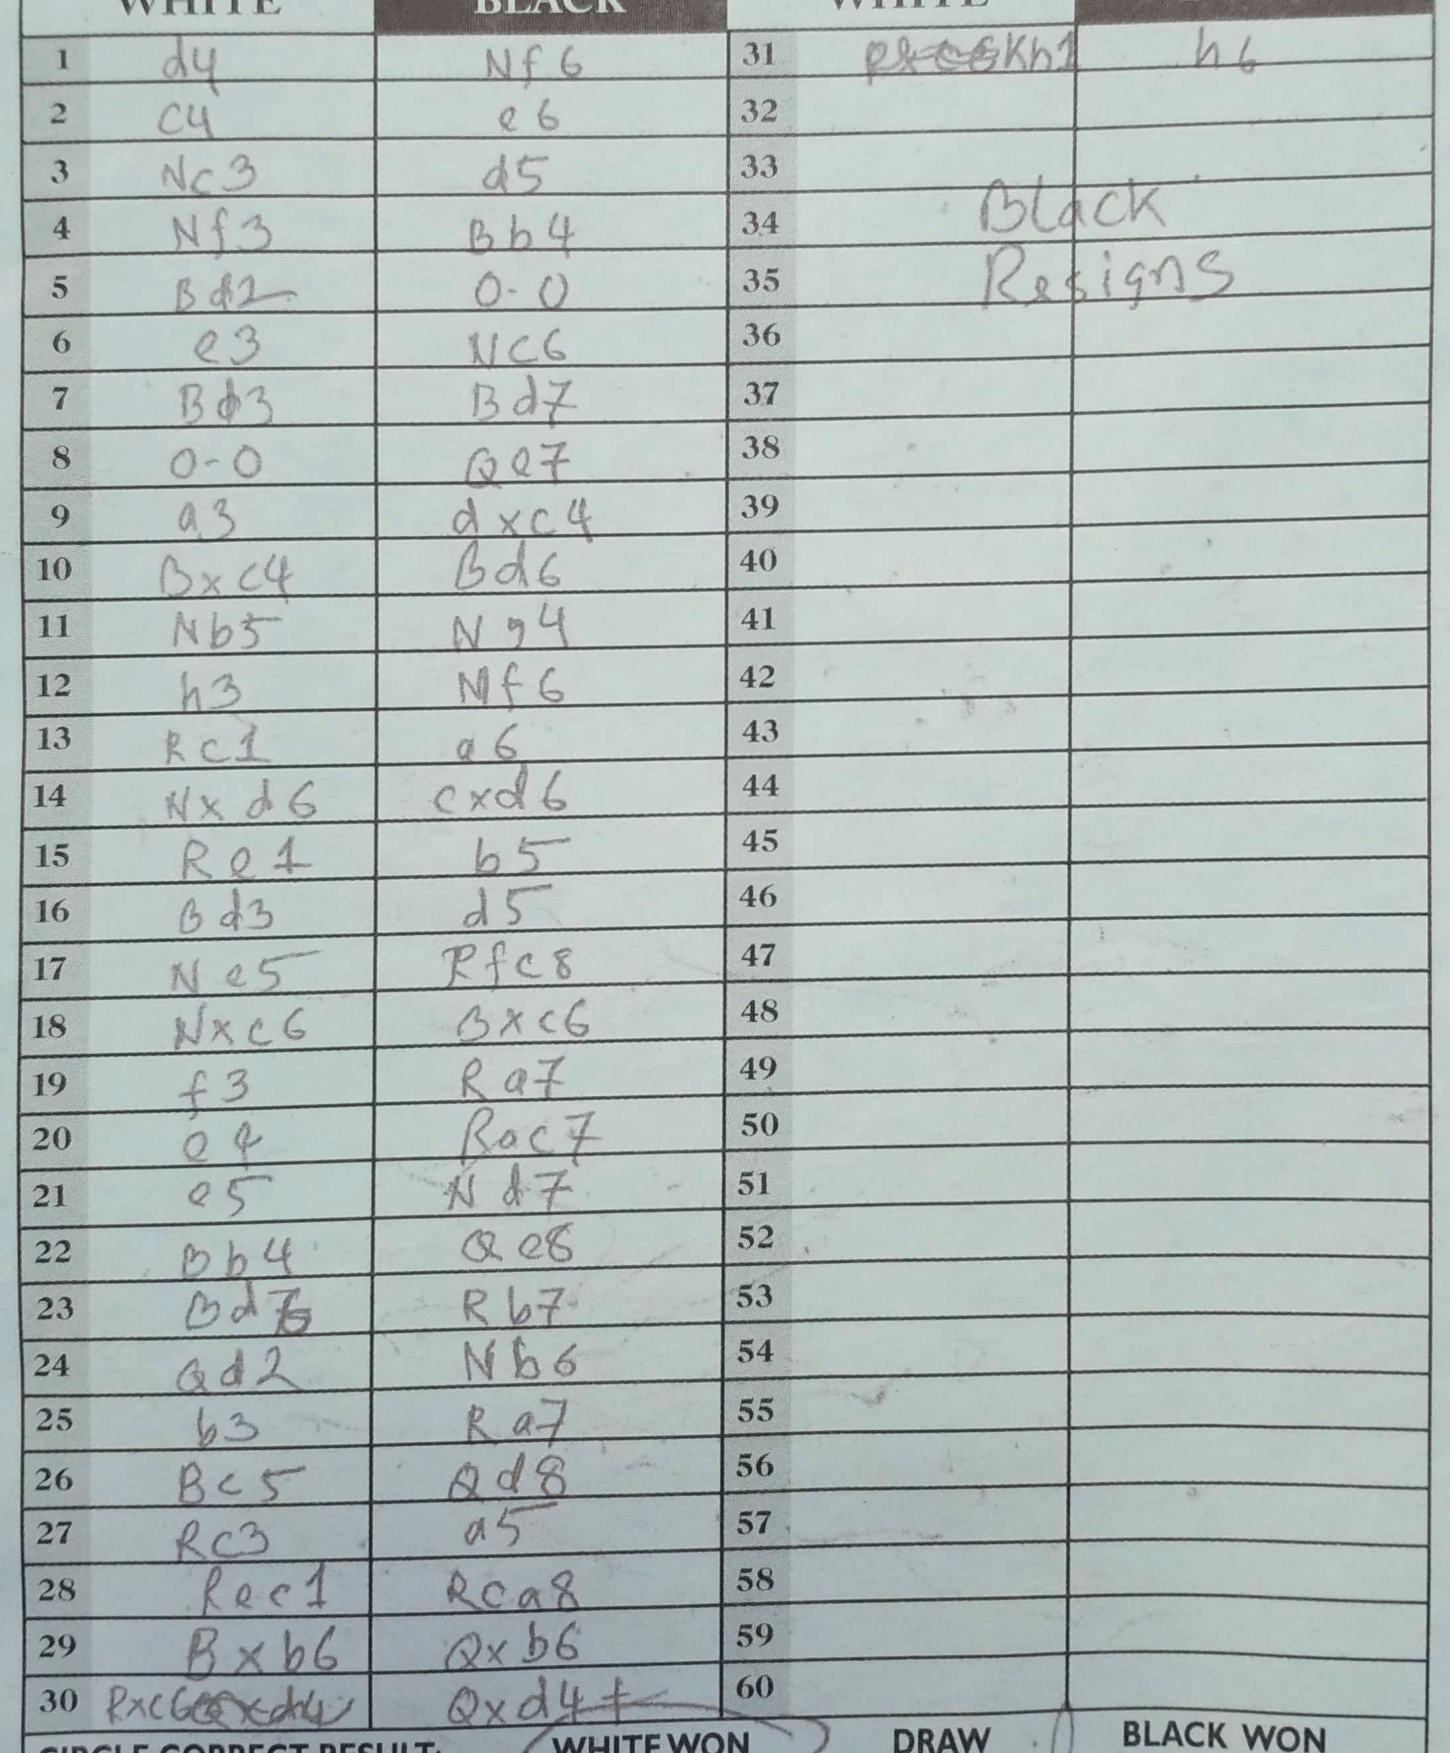

In [12]:
from PIL import Image
Image.fromarray(a[0].image)
Image.fromarray(n4)


In [11]:
[n1, n2, n3][0]


array([[[177, 193, 191],
        [175, 193, 189],
        [177, 193, 191],
        ...,
        [185, 199, 197],
        [185, 199, 197],
        [185, 199, 197]],

       [[177, 193, 191],
        [175, 193, 189],
        [175, 193, 189],
        ...,
        [185, 199, 197],
        [185, 199, 197],
        [185, 199, 197]],

       [[177, 196, 191],
        [175, 193, 189],
        [177, 193, 191],
        ...,
        [185, 199, 197],
        [185, 199, 197],
        [185, 199, 197]],

       ...,

       [[168, 188, 184],
        [168, 191, 191],
        [172, 192, 188],
        ...,
        [123, 139, 139],
        [123, 139, 139],
        [123, 141, 143]],

       [[168, 188, 184],
        [168, 191, 191],
        [172, 192, 188],
        ...,
        [123, 139, 139],
        [123, 139, 139],
        [129, 142, 145]],

       [[168, 188, 187],
        [168, 191, 191],
        [168, 191, 191],
        ...,
        [129, 142, 145],
        [123, 141, 143],
        [129, 142, 145]]

In [5]:
import sklearn

X = [n1, n2, n3]
y = [0, 1, 2]
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
a = neigh.kneighbors([n4, n2], n_neighbors=3)
# print(neigh.predict_proba([[0.9]]))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [33]:
a

(array([[3.72529030e-09, 1.48489591e-01, 2.70172088e-01],
        [3.72529030e-09, 2.44344097e-01, 2.70172088e-01]]),
 array([[2, 0, 1],
        [1, 0, 2]]))

In [12]:
from __future__ import print_function

from scipy import spatial
import numpy as np

from typing import Literal


class Evaluation(object):

    def make_samples(self):
        raise NotImplementedError("Needs to implemented this method")


def distance(
    v1, v2, d_type: Literal["absolute", "cosine", "square", "d2-norm"] = "cosine"
):
    assert v1.shape == v2.shape, "shape of two vectors need to be same!"

    if d_type == "absolute":
        return np.sum(np.absolute(v1 - v2))
    elif d_type == "d2-norm":
        return 2 - 2 * np.dot(v1, v2)
    elif d_type == "cosine":
        return spatial.distance.cosine(v1, v2)
    elif d_type == "square":
        return np.sum((v1 - v2) ** 2)
    else:
        raise ValueError(f"Invalid distance type: {d_type}")

In [13]:
distance(n1, n2)

0.8279867590363326

In [5]:
n1 - n2

array([0., 0., 0., ..., 0., 0., 0.])

In [3]:
n.shape

(4608,)

In [ ]:
1728

In [2]:
import numpy as np

with open("histogram.bin", "rb") as f:
    o = np.load(f)

In [22]:
# import numpy as np
# with open("histogram.bin", "wb") as f:
#     np.save(f, n)

In [5]:
hist = rgb_histogram("/home/rhev/Works/Code/CV-basic/data/prj1-4/009_0.png")

In [6]:
hist.shape

(15552,)